# Predicting the Photo-voltaic energy production

This Notebook aims at predicting the energy producte by solar pannel.

It uses weather data extracted from the MeteoFrance numerical models, as well as history of productions provided by RTE.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filename_ssrd_regions = "./all_ssrd_regions.parquet"
filename_energy_preduction = "../../clean_datasets/rte_agg_daily_2014_2024.csv"

,île_de_france,centre_val_de_loire,bourgogne_franche_comté,normandie,hauts_de_france,grand_est,pays_de_la_loire,bretagne,nouvelle_aquitaine,occitanie,auvergne_rhône_alpes,provence_alpes_côte_d_azur,corse,days_from_start
time,,,,,,,,,,,,,,
2022-02-01,53159640.0,3.908431e+08,1.246165e+09,3.758113e+08,2.069317e+08,7.566696e+08,1.143252e+09,1.287486e+09,4.331143e+09,6.206675e+09,5.165560e+09,3.607569e+09,1.030286e+09,0
2022-02-02,258439040.0,1.841640e+09,8.192174e+08,1.375505e+09,6.444299e+08,6.151782e+08,2.289697e+09,1.771655e+09,5.628156e+09,5.743926e+09,3.907394e+09,3.642998e+09,1.028322e+09,1
2022-02-03,307017760.0,1.689794e+09,2.614429e+09,4.179857e+08,4.714450e+08,2.094549e+09,1.119362e+09,6.392717e+08,5.102089e+09,6.738771e+09,5.909604e+09,3.250151e+09,9.223640e+08,2
2022-02-04,399195456.0,1.037464e+09,1.810483e+09,1.460257e+09,1.166828e+09,1.465504e+09,1.576880e+09,1.798407e+09,2.630984e+09,4.681148e+09,5.627480e+09,3.304997e+09,7.455214e+08,3
2022-02-05,962711936.0,3.476773e+09,4.760457e+09,2.328465e+09,2.518373e+09,4.102497e+09,3.166515e+09,2.510318e+09,9.428851e+09,6.397867e+09,7.168189e+09,3.745298e+09,7.002952e+08,4


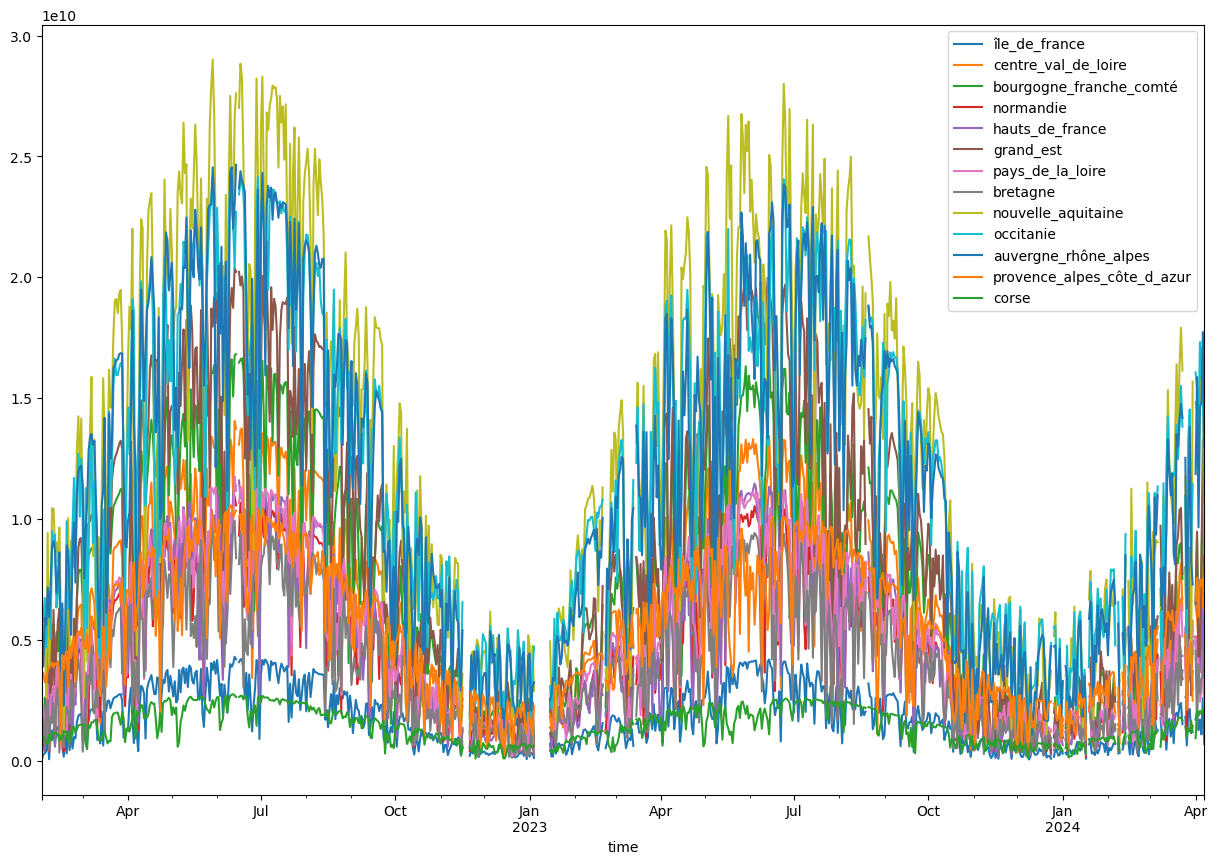

In [3]:
df_ssrd_regions = pd.read_parquet(filename_ssrd_regions)
# sanitise the column names
region_names = [
    col.replace(" ", "_").replace("'", "_").replace("-", "_").lower()
    for col in df_ssrd_regions.columns
]
df_ssrd_regions.columns = region_names
region_names = df_ssrd_regions.columns
df_ssrd_regions = df_ssrd_regions.resample(
    "D"
).mean()  # Doing so to add empty rows for missing days
df_ssrd_regions.plot(figsize=(15, 10))
df_ssrd_regions["days_from_start"] = [
    (date - df_ssrd_regions.index[0]).days for date in df_ssrd_regions.index
]
df_ssrd_regions.head()

In [4]:
df_energy_preduction = pd.read_csv(filename_energy_preduction, index_col=0)[["Solaire"]]
df_energy_preduction.index = pd.to_datetime(df_energy_preduction.index)
df_energy_preduction.head(), df_energy_preduction.tail()

(            Solaire
 Date               
 2015-01-01  11370.5
 2015-01-02   8297.5
 2015-01-03   5860.5
 2015-01-04   6926.0
 2015-01-05   9786.5,
             Solaire
 Date               
 2024-04-04  76581.5
 2024-04-05  72847.5
 2024-04-06  61577.5
 2024-04-07  46718.5
 2024-04-08  26677.0)

In [5]:
df_energy_preduction.index

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2024-03-30', '2024-03-31', '2024-04-01', '2024-04-02',
               '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-06',
               '2024-04-07', '2024-04-08'],
              dtype='datetime64[ns]', name='Date', length=3386, freq=None)

In [6]:
# align the indexes of the two dataframes
data = pd.concat([df_ssrd_regions, df_energy_preduction], join="inner", axis=1)
data.head()

,île_de_france,centre_val_de_loire,bourgogne_franche_comté,normandie,hauts_de_france,grand_est,pays_de_la_loire,bretagne,nouvelle_aquitaine,occitanie,auvergne_rhône_alpes,provence_alpes_côte_d_azur,corse,days_from_start,Solaire
2022-02-01,53159640.0,3.908431e+08,1.246165e+09,3.758113e+08,2.069317e+08,7.566696e+08,1.143252e+09,1.287486e+09,4.331143e+09,6.206675e+09,5.165560e+09,3.607569e+09,1.030286e+09,0,21938.5
2022-02-02,258439040.0,1.841640e+09,8.192174e+08,1.375505e+09,6.444299e+08,6.151782e+08,2.289697e+09,1.771655e+09,5.628156e+09,5.743926e+09,3.907394e+09,3.642998e+09,1.028322e+09,1,21271.0
2022-02-03,307017760.0,1.689794e+09,2.614429e+09,4.179857e+08,4.714450e+08,2.094549e+09,1.119362e+09,6.392717e+08,5.102089e+09,6.738771e+09,5.909604e+09,3.250151e+09,9.223640e+08,2,20527.5
2022-02-04,399195456.0,1.037464e+09,1.810483e+09,1.460257e+09,1.166828e+09,1.465504e+09,1.576880e+09,1.798407e+09,2.630984e+09,4.681148e+09,5.627480e+09,3.304997e+09,7.455214e+08,3,19051.0
2022-02-05,962711936.0,3.476773e+09,4.760457e+09,2.328465e+09,2.518373e+09,4.102497e+09,3.166515e+09,2.510318e+09,9.428851e+09,6.397867e+09,7.168189e+09,3.745298e+09,7.002952e+08,4,41271.5


In [7]:
from statsmodels.formula.api import ols

# split test for time series
from sklearn.model_selection import TimeSeriesSplit

# Modeling

4 models are tested :
- Only Total sun flux (no region details)
- Only regions sun flux (no time feature)
- Total sun flux + time
- Regions sun flux + time

The Time feature allows to model a trend in the number of installed solar pannels.

In [8]:
exo_vars = df_ssrd_regions.columns
exo_vars = exo_vars.drop("days_from_start")
data["mean_sun"] = data[exo_vars].mean(axis=1)
endog_var = "Solaire"

In [27]:
tscv = TimeSeriesSplit(n_splits=30, test_size=4)  # testing on 4 days forcast

In [28]:
def test_model(formula="Solaire ~ mean_sun"):
    mod_1_mape = []
    for i, (train_index, test_index) in enumerate(tscv.split(data)):
        model_1 = ols(formula, data=data.iloc[train_index]).fit()
        if i == 0:
            first_test_index = test_index
            first_model_1 = model_1
        predictions = model_1.predict(data.iloc[test_index])
        error = data.iloc[test_index]["Solaire"] - predictions
        mape = (error.abs() / data.iloc[test_index]["Solaire"]).mean()
        mod_1_mape.append(mape)
    last_test_index = test_index
    last_model_1 = model_1
    return mod_1_mape, first_test_index, first_model_1, last_test_index, last_model_1


mod_1_mape, first_test_index, first_model_1, last_test_index, last_model_1 = (
    test_model()
)

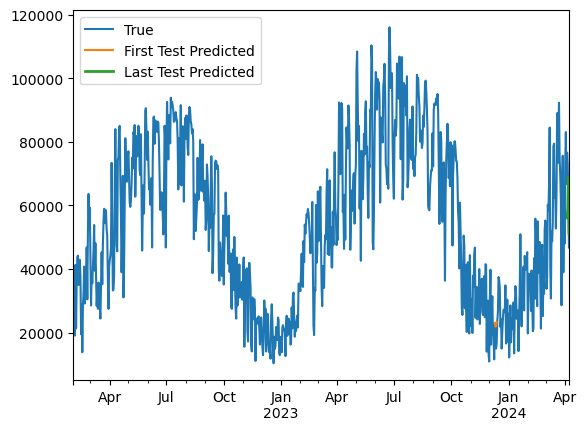

In [29]:
ax = data.plot(y="Solaire", label="True")
first_model_1.predict(data.iloc[first_test_index]).plot(
    ax=ax, label="First Test Predicted"
)
last_model_1.predict(data.iloc[last_test_index]).plot(
    ax=ax, label="Last Test Predicted", lw=2
)

ax.legend()

Text(0.5, 0, 'MAPE')

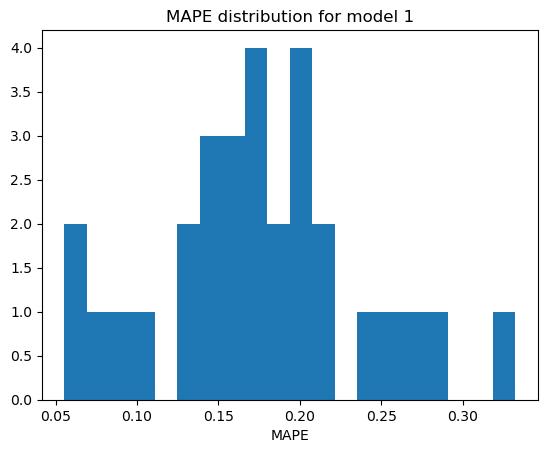

In [30]:
fig, ax = plt.subplots()
ax.hist(mod_1_mape, bins=20)
ax.set_title("MAPE distribution for model 1")
ax.set_xlabel("MAPE")

In [31]:
formula_2 = f"Solaire ~ {' + '.join(exo_vars)}"
print(formula_2)
mod_2_mape, first_test_index, first_model_2, last_test_index, last_model_2 = test_model(
    formula_2
)

Solaire ~ île_de_france + centre_val_de_loire + bourgogne_franche_comté + normandie + hauts_de_france + grand_est + pays_de_la_loire + bretagne + nouvelle_aquitaine + occitanie + auvergne_rhône_alpes + provence_alpes_côte_d_azur + corse


Text(0.5, 1.0, 'MAPE distribution for model 2')

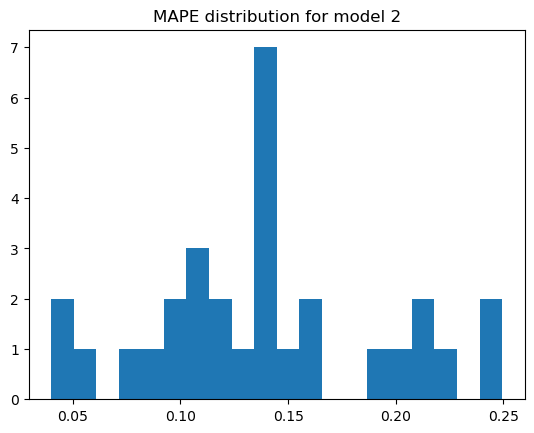

In [32]:
fig, ax = plt.subplots()
ax.hist(mod_2_mape, bins=20)
ax.set_title("MAPE distribution for model 2")

In [33]:
formula_3 = "Solaire ~ mean_sun + days_from_start"
mod_3_mape, first_test_index, first_model_3, last_test_index, last_model_3 = test_model(
    formula_3
)
formula_4 = f"Solaire ~ {' + '.join(exo_vars)} + days_from_start"
mod_4_mape, first_test_index, first_model_4, last_test_index, last_model_4 = test_model(
    formula_4
)

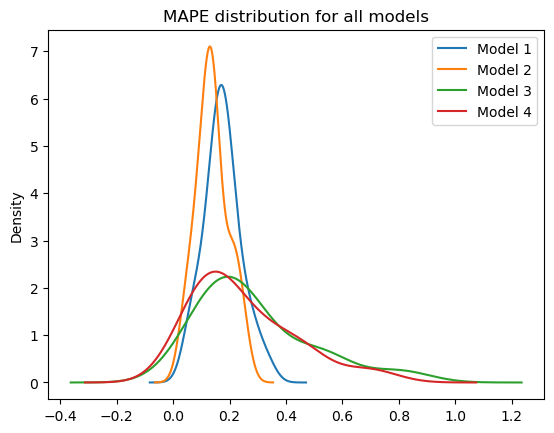

In [34]:
# display the MAPE distribution for all models (KDE)
fig, ax = plt.subplots()
for i, mape in enumerate([mod_1_mape, mod_2_mape, mod_3_mape, mod_4_mape]):
    pd.Series(mape).plot.kde(ax=ax, label=f"Model {i+1}")
ax.set_title("MAPE distribution for all models")
ax.legend()

In [35]:
# print mean MAPE for all models
for i, mape in enumerate([mod_1_mape, mod_2_mape, mod_3_mape, mod_4_mape]):
    print(f"Model {i+1} mean MAPE: {np.mean(mape):.2%}")

Model 1 mean MAPE: 17.44%
Model 2 mean MAPE: 13.83%
Model 3 mean MAPE: 28.84%
Model 4 mean MAPE: 24.85%


# Conclusion

The model performances doesn't really follow the expected order (more feature => better performance)

Maybe this is due to some sort of over-fitting, even thought there are not so mainy features...